# Data Sampling and Feature Building

### First, we will sample the data for training and testing our model. This step is required as the whole dataset is quite large and we don't possess the computational power to deal with it.

### Loading the 'review.json' file:

In [1]:
import pandas as pd
import json
from tqdm import tqdm

line_count = len(open("dataset/review.json").readlines())
user_ids, business_ids, stars, dates, texts, usefuls = [], [], [], [], [], []
with open("dataset/review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]] 
        business_ids += [blob["business_id"]] 
        stars += [blob["stars"]]
        dates += [blob["date"]]
        texts += [blob["text"]]
        usefuls += [blob["useful"]]
ratings = pd.DataFrame({"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates, "text":texts, "useful": usefuls})
user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [00:48<00:00, 138696.59it/s]


In [2]:
ratings.shape

(6685900, 6)

### Loading the 'business.json' file:

In [3]:
line_count = len(open("dataset/business.json").readlines())
business_ids, biz_stars, biz_rev_ct, cats, states, cities, is_open = [], [], [], [], [], [], []
with open("dataset/business.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        business_ids += [blob["business_id"]] 
        biz_stars += [blob["stars"]]
        biz_rev_ct += [blob["review_count"]]
        cats += [blob["categories"]]
        states += [blob["state"]]
        cities += [blob["city"]]
        is_open += [blob["is_open"]]
        
biz = pd.DataFrame({"business_id": business_ids, "cat": cats, "biz_stars":biz_stars, "biz_rev_ct":biz_rev_ct, 
                    "state":states, "city":cities, "is_open":is_open})


100%|██████████| 192609/192609 [00:02<00:00, 89470.84it/s]


### Loading the 'user.json' file:

In [4]:
line_count = len(open("dataset/user.json").readlines())
user_id, avg_stars, fans = [], [], []
with open("dataset/user.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_id += [blob["user_id"]] 
        avg_stars += [blob["average_stars"]]
        fans += [blob["fans"]]
        
users = pd.DataFrame({"user_id": user_id, "avg_stars": avg_stars, "fans": fans})



100%|██████████| 1637138/1637138 [00:17<00:00, 93440.72it/s] 


### Filtering the businesses which have 'Food' and 'Restaurant' in their categories to get more relevant businesses:

In [5]:
rest_food_biz = biz[(biz["cat"].str.contains("Food") == True) & (biz["cat"].str.contains("Restaurant") == True)].reset_index()

In [6]:
rest_food_biz.head()

,index,business_id,cat,biz_stars,biz_rev_ct,state,city,is_open
0,1,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",2.5,128,ON,Mississauga,1
1,11,1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",3.0,18,AZ,Phoenix,1
2,23,1RHY4K3BD22FK7Cfftn8Mg,"Sandwiches, Salad, Restaurants, Burgers, Comfo...",4.0,35,PA,Pittsburgh,1
3,25,tstimHoMcYbkSC4eBA1wEg,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",4.5,184,NV,Las Vegas,1
4,29,NDuUMJfrWk52RA-H-OtrpA,"Juice Bars & Smoothies, Food, Restaurants, Fas...",3.0,57,ON,Toronto,1


### Splitting the categories:

In [7]:
food_rest_cat_list = []
for i in range(rest_food_biz.shape[0]):
    try:
        var_list = rest_food_biz.loc[i, "cat"].split(',')
        var_list = [j.strip() for j in var_list]
        food_rest_cat_list.append(var_list)
    except:
        food_rest_cat_list.append([])

rest_food_biz['cat_list'] = food_rest_cat_list
rest_food_biz['cat_list'].head()


0    [Specialty Food, Restaurants, Dim Sum, Importe...
1    [Restaurants, Breakfast & Brunch, Mexican, Tac...
2    [Sandwiches, Salad, Restaurants, Burgers, Comf...
3    [Mexican, Restaurants, Patisserie/Cake Shop, F...
4    [Juice Bars & Smoothies, Food, Restaurants, Fa...
Name: cat_list, dtype: object

Checking the total number of categories:

In [8]:
rest_food_list = []

for i in rest_food_biz['cat_list']:
    rest_food_list.extend(i)

len(set(rest_food_list))

547

### Transforming business categoires list to multi-labeled binary columns:

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

s = rest_food_biz['cat_list']
mlb = MultiLabelBinarizer()
biz_cats = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=rest_food_biz.index)

In [10]:
biz_cats.head()

,& Probates,Acai Bowls,Accessories,Active Life,Adult Entertainment,Afghan,African,Air Duct Cleaning,Aircraft Repairs,Airport Lounges,...,Wine & Spirits,Wine Bars,Wine Tasting Classes,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Taking the categories which appear in more than 500 businesses:

In [11]:
sums = biz_cats.sum(axis =0)
sums = pd.DataFrame(sums)
sums["cats"] = sums.index
sums = sums.reset_index(drop=True)
sums.columns = ["value", "key"]
sums = sums[sums["value"]>=500]
cols = list(sums["key"])
cols

['American (New)',
 'American (Traditional)',
 'Asian Fusion',
 'Bakeries',
 'Barbeque',
 'Bars',
 'Beer',
 'Breakfast & Brunch',
 'Burgers',
 'Cafes',
 'Canadian (New)',
 'Caterers',
 'Chicken Wings',
 'Chinese',
 'Coffee & Tea',
 'Comfort Food',
 'Delis',
 'Desserts',
 'Ethnic Food',
 'Event Planning & Services',
 'Fast Food',
 'Food',
 'Food Delivery Services',
 'Food Trucks',
 'Grocery',
 'Ice Cream & Frozen Yogurt',
 'Italian',
 'Juice Bars & Smoothies',
 'Mexican',
 'Nightlife',
 'Pizza',
 'Restaurants',
 'Salad',
 'Sandwiches',
 'Seafood',
 'Specialty Food',
 'Wine & Spirits']

In [12]:
biz_cats = biz_cats[cols]
biz_cats.shape

(21315, 37)

### Joining the new multi-label binary columns to the main dataset:

In [13]:
rest_food_biz = pd.concat([rest_food_biz, biz_cats], axis = 1)
rest_food_biz.shape

(21315, 46)

In [14]:
rest_food_sub = rest_food_biz

### Merging 'ratings' and the new modified business dataset:

In [15]:
review_sub = ratings.merge(rest_food_sub)
review_sub.shape

(1374850, 51)

### Filtering the active users (have given more than 5 reviews):

In [16]:
user_counts = review_sub["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

In [17]:
review_sub_1 = review_sub[review_sub["user_id"].isin(active_users)]
len(set(review_sub_1["user_id"]))

52550

### Here, we can see that we have above 50,000 users. Thus, this sample is ready to be worked with.

In [18]:
review_sub_final = review_sub_1.merge(users)

In [19]:
review_sub_final.shape

(629155, 53)

### Randomizing the rows in the sample data:

In [20]:
review_sub_final = review_sub_final.sample(frac = 1, random_state = 69)
review_sub_final.columns

Index(['user_id', 'business_id', 'rating', 'date', 'text', 'useful', 'index',
       'cat', 'biz_stars', 'biz_rev_ct', 'state', 'city', 'is_open',
       'cat_list', 'American (New)', 'American (Traditional)', 'Asian Fusion',
       'Bakeries', 'Barbeque', 'Bars', 'Beer', 'Breakfast & Brunch', 'Burgers',
       'Cafes', 'Canadian (New)', 'Caterers', 'Chicken Wings', 'Chinese',
       'Coffee & Tea', 'Comfort Food', 'Delis', 'Desserts', 'Ethnic Food',
       'Event Planning & Services', 'Fast Food', 'Food',
       'Food Delivery Services', 'Food Trucks', 'Grocery',
       'Ice Cream & Frozen Yogurt', 'Italian', 'Juice Bars & Smoothies',
       'Mexican', 'Nightlife', 'Pizza', 'Restaurants', 'Salad', 'Sandwiches',
       'Seafood', 'Specialty Food', 'Wine & Spirits', 'avg_stars', 'fans'],
      dtype='object')

### Changing the type of 'date' column to date:

In [21]:
review_sub_final['date'] = review_sub_final['date'].astype(str)

### Removing the category list column as we have already made multi-label binary columns:

In [22]:
review_sub_final = review_sub_final.drop('cat_list',axis=1)

In [23]:
#review_sub_final.to_csv("yelp_sampledata_rest_food.csv")

### Start of making new features for users and for the businesses:  

## Derived User Features:
We are making new features the represents the taste of users. In this, we will try to see how many times the user has rated a restaurant with a particular category.e.g if the user has rated Italian food the most, this will give us some sense that user likes Italian food. We will make columns for all the categories we have and in each cell will be the number of times the corresponding user has rated it.

## Derived Business features:
We are also making new, derived features to represent businesses. The idea here is we give more weightage to the ratings where more people found it useful and then get weighted average for the business based on that.e.g. there is a business A which has two reviews: 4.5 and 1, and 100, 10 people found them useful respectively. Here the weighted average for that business will be: (4.5x100 + 1x10)/110 = 4.18. This is an idea to capture the more relavant reviews to get the average rating for the business.

In [24]:
data = review_sub_final

In [25]:
data.columns

Index(['user_id', 'business_id', 'rating', 'date', 'text', 'useful', 'index',
       'cat', 'biz_stars', 'biz_rev_ct', 'state', 'city', 'is_open',
       'American (New)', 'American (Traditional)', 'Asian Fusion', 'Bakeries',
       'Barbeque', 'Bars', 'Beer', 'Breakfast & Brunch', 'Burgers', 'Cafes',
       'Canadian (New)', 'Caterers', 'Chicken Wings', 'Chinese',
       'Coffee & Tea', 'Comfort Food', 'Delis', 'Desserts', 'Ethnic Food',
       'Event Planning & Services', 'Fast Food', 'Food',
       'Food Delivery Services', 'Food Trucks', 'Grocery',
       'Ice Cream & Frozen Yogurt', 'Italian', 'Juice Bars & Smoothies',
       'Mexican', 'Nightlife', 'Pizza', 'Restaurants', 'Salad', 'Sandwiches',
       'Seafood', 'Specialty Food', 'Wine & Spirits', 'avg_stars', 'fans'],
      dtype='object')

In [26]:
data = data.drop(["Restaurants", "Food", "cat"], axis = 1)

In [27]:
data.head()

,user_id,business_id,rating,date,text,useful,index,biz_stars,biz_rev_ct,state,...,Mexican,Nightlife,Pizza,Salad,Sandwiches,Seafood,Specialty Food,Wine & Spirits,avg_stars,fans
529719,rMnTpVfJyH_fWgf9TICCYg,RESDUcs7fIiihp38-d6_6g,5.0,2016-01-05 03:07:40,"I can't remember if I dreamt this or not, beca...",0,89206,4.0,8339,NV,...,0,0,0,0,1,0,0,0,4.72,16
436195,s_Dg0gNZmh-Vc6yLQ34_lw,mzq_UgBRWsxTjb7oBNajWA,3.0,2015-12-06 22:17:18,I've been to this Great Dane location a few ti...,1,140502,3.5,218,WI,...,0,1,0,0,0,0,0,0,3.72,13
427897,MTB3KvE5NCiQSO5QOvAilw,ae95XSsD37OQfOWF92GjNQ,3.0,2015-08-23 10:06:06,Was here for a birthday celebration and we sat...,0,160767,3.5,309,ON,...,0,0,0,0,0,0,1,0,2.98,2
165802,pMefTWo6gMdx8WhYSA2u3w,aXnWWp6Reaep4-0iKWlYHQ,4.0,2013-10-09 23:22:52,I was told by a fellow Yelp member a few night...,3,43947,3.5,113,ON,...,0,0,0,0,0,0,0,0,3.40,57
167874,_jvpuLE8claM2mi6jMKXOA,UJewG9UgVXQ7fyP4UHwnxw,1.0,2015-08-30 05:39:00,I am done with this location. \n\nMy carne asa...,7,160039,2.5,131,AZ,...,1,0,0,0,0,0,0,0,3.67,8


## Making user features:

### Retaining names of columns which are related to the categories:

In [28]:
cols2 = []
for x in data.columns:
    if x in cols:
        cols2.append(x)

### Summing up the number of ratings for all the categories for each user:

In [29]:
user_feat_data = data.groupby(["user_id"], as_index=False).sum()

In [30]:
user_feat_data.head()

,user_id,rating,useful,index,biz_stars,biz_rev_ct,is_open,American (New),American (Traditional),Asian Fusion,...,Mexican,Nightlife,Pizza,Salad,Sandwiches,Seafood,Specialty Food,Wine & Spirits,avg_stars,fans
0,---1lKK3aKOuomHnwAkAow,70.0,31,2130846,63.5,8321,11,8,3,1,...,0,5,2,0,5,3,2,1,66.64,272
1,--2HUmLkcNHZp0xw6AMBPg,104.0,6,2068382,86.0,6437,19,4,3,0,...,5,1,1,0,7,1,1,1,101.20,0
2,--3WaS23LcIXtxyFULJHTA,25.0,6,547508,25.5,6851,5,2,0,0,...,0,2,0,2,3,0,0,0,23.52,66
3,--4rAAfZnEIAKJE80aIiYg,24.0,5,550808,26.5,2152,6,1,0,2,...,0,0,1,1,3,0,0,0,16.52,0
4,--BumyUHiO_7YsHurb9Hkw,99.0,10,2195072,96.5,6664,22,1,0,1,...,3,4,1,2,6,0,5,2,94.56,24


In [31]:
cols2.append('user_id')
user_feat_data = user_feat_data[cols2]

In [32]:
user_feat_data.head()

,American (New),American (Traditional),Asian Fusion,Bakeries,Barbeque,Bars,Beer,Breakfast & Brunch,Burgers,Cafes,...,Juice Bars & Smoothies,Mexican,Nightlife,Pizza,Salad,Sandwiches,Seafood,Specialty Food,Wine & Spirits,user_id
0,8,3,1,2,0,5,1,6,2,4,...,4,0,5,2,0,5,3,2,1,---1lKK3aKOuomHnwAkAow
1,4,3,0,3,0,1,1,7,3,1,...,2,5,1,1,0,7,1,1,1,--2HUmLkcNHZp0xw6AMBPg
2,2,0,0,2,0,2,0,3,0,4,...,0,0,2,0,2,3,0,0,0,--3WaS23LcIXtxyFULJHTA
3,1,0,2,0,1,0,0,3,1,0,...,0,0,0,1,1,3,0,0,0,--4rAAfZnEIAKJE80aIiYg
4,1,0,1,3,0,4,2,5,0,6,...,0,3,4,1,2,6,0,5,2,--BumyUHiO_7YsHurb9Hkw


### Giving new names to the new built feature-set so that it does not confuses the original category columns. The new columns are named as: [category]_urating

In [33]:
l = []

for i in range(len(user_feat_data.columns)):
    if user_feat_data.columns[i] != "user_id":
        l.append(str(user_feat_data.columns[i])+"_urating")
    else:
        l.append('user_id')

user_feat_data.columns = l

In [34]:
user_feat_data.head()

,American (New)_urating,American (Traditional)_urating,Asian Fusion_urating,Bakeries_urating,Barbeque_urating,Bars_urating,Beer_urating,Breakfast & Brunch_urating,Burgers_urating,Cafes_urating,...,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,user_id
0,8,3,1,2,0,5,1,6,2,4,...,4,0,5,2,0,5,3,2,1,---1lKK3aKOuomHnwAkAow
1,4,3,0,3,0,1,1,7,3,1,...,2,5,1,1,0,7,1,1,1,--2HUmLkcNHZp0xw6AMBPg
2,2,0,0,2,0,2,0,3,0,4,...,0,0,2,0,2,3,0,0,0,--3WaS23LcIXtxyFULJHTA
3,1,0,2,0,1,0,0,3,1,0,...,0,0,0,1,1,3,0,0,0,--4rAAfZnEIAKJE80aIiYg
4,1,0,1,3,0,4,2,5,0,6,...,0,3,4,1,2,6,0,5,2,--BumyUHiO_7YsHurb9Hkw


### Merging the user feature-set with the previous sample data, on 'user_id'

In [35]:
merged_data = data.merge(user_feat_data)

In [36]:
len(data["user_id"])

629155

In [37]:
len(set(list(data["user_id"])))

52550

In [38]:
len(user_feat_data["user_id"])

52550

In [39]:
len(merged_data["user_id"])

629155

In [40]:
merged_data.head()

,user_id,business_id,rating,date,text,useful,index,biz_stars,biz_rev_ct,state,...,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating
0,rMnTpVfJyH_fWgf9TICCYg,RESDUcs7fIiihp38-d6_6g,5.0,2016-01-05 03:07:40,"I can't remember if I dreamt this or not, beca...",0,89206,4.0,8339,NV,...,0,1,0,2,1,1,1,0,1,1
1,rMnTpVfJyH_fWgf9TICCYg,RVQE2Z2uky4c0-njFQO66g,5.0,2014-09-22 20:35:17,My favorite meal in Charlotte. Definitely try ...,0,148503,4.5,1474,NC,...,0,1,0,2,1,1,1,0,1,1
2,rMnTpVfJyH_fWgf9TICCYg,l3jXlEDlVfKj_ECpU7tobA,5.0,2014-09-23 00:36:57,Fantastic spot for whiskey and pre/post Jaguar...,0,39475,3.5,248,NC,...,0,1,0,2,1,1,1,0,1,1
3,rMnTpVfJyH_fWgf9TICCYg,ciHtNE7zKzr25IX_L6pNSQ,5.0,2018-07-12 14:10:29,"I was searching for quick, healthy, and reason...",1,23927,4.0,44,ON,...,0,1,0,2,1,1,1,0,1,1
4,rMnTpVfJyH_fWgf9TICCYg,wArcCMVnrl_tc9MULW-0CQ,5.0,2014-09-22 20:32:34,We had a fantastic time on their outdoor patio...,0,118198,3.5,593,NC,...,0,1,0,2,1,1,1,0,1,1


In [41]:
merged_data = merged_data.drop(["text"], axis = 1)

In [42]:
merged_data.head()

,user_id,business_id,rating,date,useful,index,biz_stars,biz_rev_ct,state,city,...,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating
0,rMnTpVfJyH_fWgf9TICCYg,RESDUcs7fIiihp38-d6_6g,5.0,2016-01-05 03:07:40,0,89206,4.0,8339,NV,Las Vegas,...,0,1,0,2,1,1,1,0,1,1
1,rMnTpVfJyH_fWgf9TICCYg,RVQE2Z2uky4c0-njFQO66g,5.0,2014-09-22 20:35:17,0,148503,4.5,1474,NC,Charlotte,...,0,1,0,2,1,1,1,0,1,1
2,rMnTpVfJyH_fWgf9TICCYg,l3jXlEDlVfKj_ECpU7tobA,5.0,2014-09-23 00:36:57,0,39475,3.5,248,NC,Charlotte,...,0,1,0,2,1,1,1,0,1,1
3,rMnTpVfJyH_fWgf9TICCYg,ciHtNE7zKzr25IX_L6pNSQ,5.0,2018-07-12 14:10:29,1,23927,4.0,44,ON,Toronto,...,0,1,0,2,1,1,1,0,1,1
4,rMnTpVfJyH_fWgf9TICCYg,wArcCMVnrl_tc9MULW-0CQ,5.0,2014-09-22 20:32:34,0,118198,3.5,593,NC,Charlotte,...,0,1,0,2,1,1,1,0,1,1


In [43]:
data = merged_data

## Making business features:

### Taking the relevant columns required for the business' weighted average:

In [44]:
biz_data = data.loc[:, ["business_id", "useful", "rating"]]

In [45]:
biz_data.shape

(629155, 3)

### Multiplying the 'useful' and 'rating' columns, and summing it up for each business:

In [46]:
biz_data["biz_wavg"] = biz_data["useful"]*biz_data["rating"]

In [47]:
biz_data = biz_data.groupby("business_id", as_index = False).sum()

In [48]:
biz_data.head()

,business_id,useful,rating,biz_wavg
0,--FBCX-N37CMYDfs790Bnw,66,251.0,237.0
1,--Ni3oJ4VOqfOEu7Sj2Vzg,2,2.0,2.0
2,--g-a85VwrdZJNf0R95GcQ,6,44.0,22.0
3,-05uZNVbb8DhFweTEOoDVg,0,3.0,0.0
4,-0BxAGlIk5DJAGVkpqBXxg,19,72.0,44.0


### Getting the weighted average by dividing the sum by total number of useful reviews for the business:

In [49]:
for i in range(biz_data.shape[0]):
    try:
        biz_data.loc[i,"biz_w_avg"]  = float(biz_data.loc[i,"biz_wavg"])/biz_data.loc[i,"useful"]
    except:
        biz_data.loc[i,"biz_w_avg"]  = 0

/Users/hargunasood/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
biz_data.head()

,business_id,useful,rating,biz_wavg,biz_w_avg
0,--FBCX-N37CMYDfs790Bnw,66,251.0,237.0,3.590909
1,--Ni3oJ4VOqfOEu7Sj2Vzg,2,2.0,2.0,1.000000
2,--g-a85VwrdZJNf0R95GcQ,6,44.0,22.0,3.666667
3,-05uZNVbb8DhFweTEOoDVg,0,3.0,0.0,NaN
4,-0BxAGlIk5DJAGVkpqBXxg,19,72.0,44.0,2.315789


In [51]:
biz_data = biz_data.fillna(0)
biz_data = biz_data.drop(["useful", "rating", "biz_wavg"], axis = 1)

### Merging the business features with the previous sample data, on 'business_id':

In [52]:
data = data.merge(biz_data)

In [53]:
data.shape

(629155, 84)

In [54]:
data.head()

,user_id,business_id,rating,date,useful,index,biz_stars,biz_rev_ct,state,city,...,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,biz_w_avg
0,rMnTpVfJyH_fWgf9TICCYg,RESDUcs7fIiihp38-d6_6g,5.0,2016-01-05 03:07:40,0,89206,4.0,8339,NV,Las Vegas,...,1,0,2,1,1,1,0,1,1,4.081165
1,3nDUQBjKyVor5wV0reJChg,RESDUcs7fIiihp38-d6_6g,4.0,2012-09-23 19:46:44,29,89206,4.0,8339,NV,Las Vegas,...,24,33,29,9,19,34,15,39,12,4.081165
2,lDKbTlZqjIn2gn490gU2HQ,RESDUcs7fIiihp38-d6_6g,4.0,2013-08-21 21:34:39,3,89206,4.0,8339,NV,Las Vegas,...,3,0,3,0,1,3,1,1,2,4.081165
3,zzPvEodjvLPe-5NvV0U_cg,RESDUcs7fIiihp38-d6_6g,5.0,2013-01-25 03:52:00,0,89206,4.0,8339,NV,Las Vegas,...,3,3,5,13,5,13,4,11,4,4.081165
4,FQbVI3UyKlL-HfQGcRF8aA,RESDUcs7fIiihp38-d6_6g,3.0,2017-01-30 00:26:04,4,89206,4.0,8339,NV,Las Vegas,...,2,2,3,0,1,4,3,6,1,4.081165


In [55]:
len(set(data["user_id"]))

52550

In [56]:
#data.to_csv("yelp_sampledata_user_biz_feat.csv")

### -This ends the data sampling and creating derived features-

# Exploratory Data Analysis of the Yelp Dataset

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

### We use Review.json, Business.json, and Users.json for our analysis of the data.

### There are 1,637,138 users who reviewed 192,609 businesses in the Yelp dataset


## Review.json

In [59]:
#import pandas as pd
import json
from tqdm import tqdm

line_count = len(open("dataset/review.json").readlines())
user_ids, business_ids, stars, dates, texts, usefuls = [], [], [], [], [], []
with open("dataset/review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]] 
        business_ids += [blob["business_id"]] 
        stars += [blob["stars"]]
        dates += [blob["date"]]
        texts += [blob["text"]]
        usefuls += [blob["useful"]]
ratings = pd.DataFrame({"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates, "text":texts, "useful": usefuls})
user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [00:48<00:00, 137415.25it/s]


### A peak into Review.json 

In [60]:
ratings.head()

,user_id,business_id,rating,date,text,useful
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36,Total bill for this horrible service? Over $8G...,6
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33,I *adore* Travis at the Hard Rock's new Kelly ...,0
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,2016-11-09 20:09:03,I have to say that this office really has it t...,3
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,2018-01-09 20:56:38,Went in for a lunch. Steak sandwich was delici...,0
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,2018-01-30 23:07:38,Today was my second out of three sessions I ha...,7


In [61]:
len(ratings)

6685900

In [62]:
ratings['user_id'].nunique()

1637138

In [63]:
ratings['business_id'].nunique()

192606

In [64]:
business_ratings = pd.DataFrame(ratings.groupby('business_id')['rating'].mean())
business_ratings['rating_counts'] = pd.DataFrame(ratings.groupby('business_id')['rating'].count())

Text(0, 0.5, 'Number of businesses')

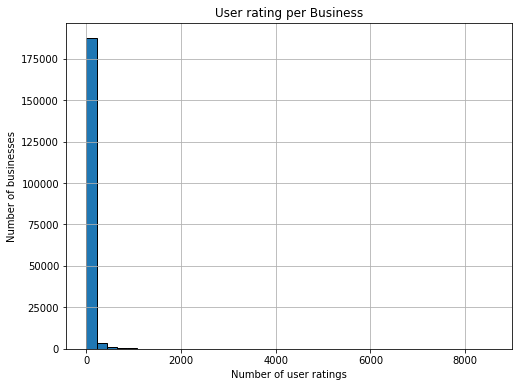

In [65]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
business_ratings['rating_counts'].hist(bins=40)
plt.title("User rating per Business")
plt.xlabel("Number of user ratings")
plt.ylabel("Number of businesses")

### We see that most businesses have few user ratings (~less than 200 ratings).

<Figure size 576x432 with 0 Axes>

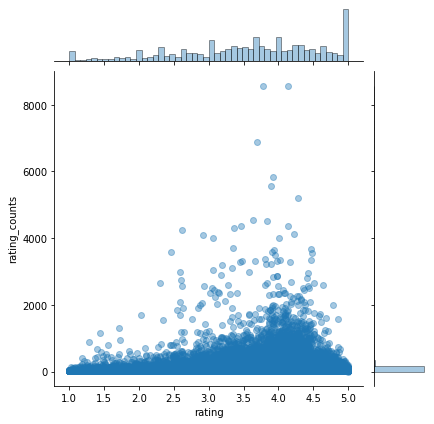

In [66]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=business_ratings, alpha=0.4)

### This is a scatter plot of the mean rating vs that total number of user ratings of a business. We see that businesses with more reviews tend to have a higher average rating. 

## Business.json

In [67]:
line_count = len(open("dataset/business.json").readlines())
business_ids, biz_stars, biz_rev_ct, cats, states, cities, is_open = [], [], [], [], [], [], []
with open("dataset/business.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        business_ids += [blob["business_id"]] 
        biz_stars += [blob["stars"]]
        biz_rev_ct += [blob["review_count"]]
        cats += [blob["categories"]]
        states += [blob["state"]]
        cities += [blob["city"]]
        is_open += [blob["is_open"]]
        
biz = pd.DataFrame({"business_id": business_ids, "cat": cats, "biz_stars":biz_stars, "biz_rev_ct":biz_rev_ct, 
                    "state":states, "city":cities, "is_open":is_open})


100%|██████████| 192609/192609 [00:06<00:00, 30920.44it/s]


### A peak into Business.json 

In [68]:
biz.head()

,business_id,cat,biz_stars,biz_rev_ct,state,city,is_open
0,1SWheh84yJXfytovILXOAQ,"Golf, Active Life",3.0,5,AZ,Phoenix,0
1,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",2.5,128,ON,Mississauga,1
2,gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",4.0,170,NC,Charlotte,1
3,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",5.0,3,AZ,Goodyear,1
4,HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",4.0,4,NC,Charlotte,1


In [69]:
is_open = pd.DataFrame(biz.groupby('is_open')['business_id'].count())
is_open

,business_id
is_open,
0,34084
1,158525


In [70]:
len(biz)

192609

### There are 34,084 businesses closed and 158,525 businesses open out of 192,609 businesses.

In [71]:
review_count = pd.DataFrame(biz.groupby('biz_rev_ct')['business_id'].count())

In [72]:
#review_count.head()

In [73]:
x = biz['biz_stars'].value_counts().index
y = biz['biz_stars'].value_counts().values

Text(0, 0.5, 'Number of businesses')

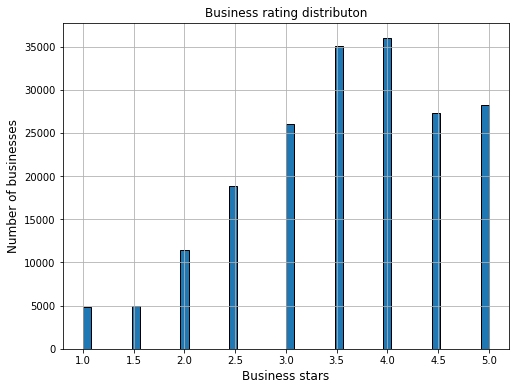

In [74]:
plt.figure(figsize=(8,6))
#ax= sns.barplot(x, y,data= biz,color="blue")
biz['biz_stars'].hist(bins=50)
plt.title("Business rating distributon")
plt.xlabel('Business stars', fontsize=12)
plt.ylabel('Number of businesses', fontsize=12)

### The bar graph above shows the distribution of business stars by number of businesses. 

In [75]:
business_cat=biz['cat'].to_string()
category=pd.DataFrame(business_cat.split(','),columns=['cat'])
x = category.cat.value_counts().sort_values(ascending=False).iloc[0:10]

Text(0, 0.5, 'Count')

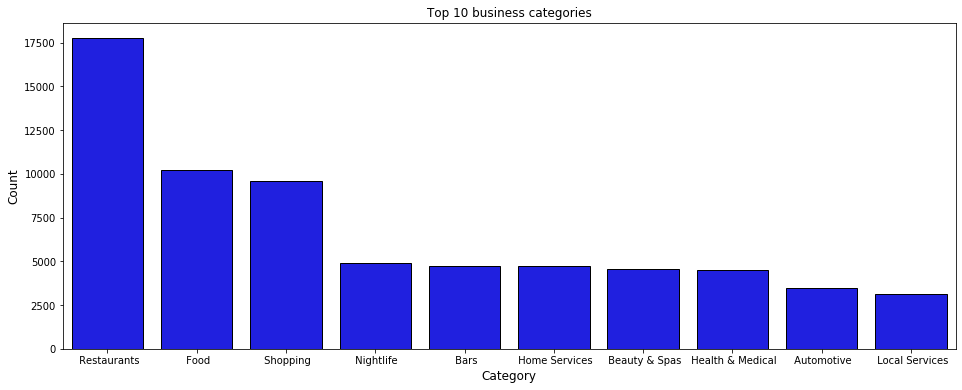

In [76]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x.index, x.values,color="blue")
locs, labels = plt.xticks()
plt.title("Top 10 business categories")
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12) #Number of businesses

### We observe that most of the businesses are restaurants/food buinesses. This is one of the reasons we chose to build a recommender sytem for restaurants/food businesses.

In [77]:
x = biz['city'].value_counts().sort_values(ascending = False).iloc[0:10]

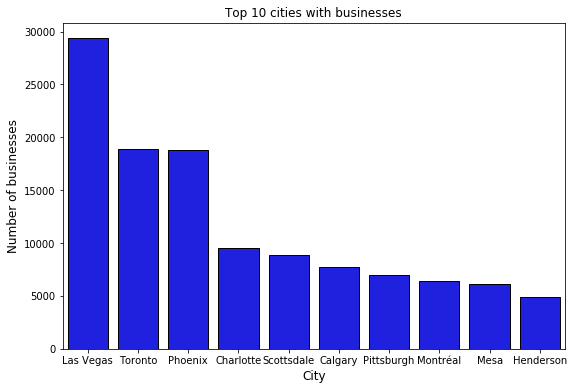

In [78]:
plt.figure(figsize=(9,6))
ax = sns.barplot(x.index, x.values,color="b")
plt.title("Top 10 cities with businesses")
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of businesses', fontsize=12)
plt.show()

### Las Vegas has the most number of businesses followed by Toronto.

## Users.json 

In [79]:
line_count = len(open("dataset/user.json").readlines())
user_id, avg_stars, fans = [], [], []
with open("dataset/user.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_id += [blob["user_id"]] 
        avg_stars += [blob["average_stars"]]
        fans += [blob["fans"]]
        
users = pd.DataFrame({"user_id": user_id, "avg_stars": avg_stars, "fans": fans})



100%|██████████| 1637138/1637138 [00:24<00:00, 66222.85it/s]


In [80]:
users.head()

,user_id,avg_stars,fans
0,l6BmjZMeQD3rDxWUbiAiow,4.03,5
1,4XChL029mKr5hydo79Ljxg,3.63,4
2,bc8C_eETBWL0olvFSJJd0w,3.71,0
3,dD0gZpBctWGdWo9WlGuhlA,4.85,5
4,MM4RJAeH6yuaN8oZDSt0RA,4.08,39


In [81]:
len(users)

1637138

plt.figure(figsize=(8,6))
#ax= sns.barplot(x, y,data= biz,color="blue")
users['avg_stars'].hist(bins=50)
plt.title("User rating distribution")
plt.xlabel('Avg stars', fontsize=12)
plt.ylabel('Number of users', fontsize=12)

### The mean rating given by most of the users is 5. There is also a spike in the number of users having a mean rating of 1.

## Exploratory Data Analysis of our sample

In [82]:
sample=pd.read_csv("dataset/yelp_sampledata_user_biz_feat.csv")

### A peak into our sample

In [83]:
sample.head()

,Unnamed: 0,user_id,business_id,rating,date,useful,index,biz_stars,biz_rev_ct,state,...,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,biz_w_avg
0,0,39VYc2nWSdvdTCldsDJ7qw,xqocOGl5Hvjc3hb1r_U4xA,5.0,2015-06-12 13:09:11,0,64478,4.0,116,ON,...,1,1,2,1,3,3,0,4,1,4.042373
1,1,X4cwQL_JZZnAUyCbOwz3pw,xqocOGl5Hvjc3hb1r_U4xA,3.0,2014-05-01 19:03:06,0,64478,4.0,116,ON,...,2,5,2,1,1,7,1,16,4,4.042373
2,2,X4cwQL_JZZnAUyCbOwz3pw,xqocOGl5Hvjc3hb1r_U4xA,4.0,2017-11-29 22:37:33,4,64478,4.0,116,ON,...,2,5,2,1,1,7,1,16,4,4.042373
3,3,X4cwQL_JZZnAUyCbOwz3pw,xqocOGl5Hvjc3hb1r_U4xA,2.0,2011-03-28 04:36:34,0,64478,4.0,116,ON,...,2,5,2,1,1,7,1,16,4,4.042373
4,4,hiCEt6RVMW7kc4pnFDjjXQ,xqocOGl5Hvjc3hb1r_U4xA,4.0,2017-12-13 22:28:31,0,64478,4.0,116,ON,...,0,1,0,0,0,3,0,1,0,4.042373


In [84]:
len(sample)

629155

In [85]:
sample['user_id'].nunique()

52550

In [86]:
sample['business_id'].nunique()

20824

### Our sample consist of 52,550 unique users who have rated 20,824 businesses.

In [87]:
s_business_ratings = pd.DataFrame(sample.groupby('business_id')['rating'].mean())
s_business_ratings['rating_counts'] = pd.DataFrame(sample.groupby('business_id')['rating'].count())

Text(0, 0.5, 'Number of restaurants')

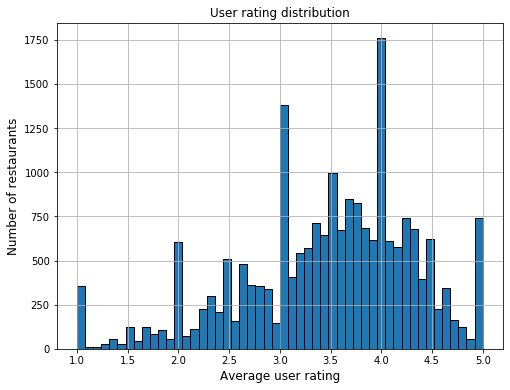

In [88]:
plt.figure(figsize=(8,6))
s_business_ratings['rating'].hist(bins=50) #np.array([ 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
#ax= sns.barplot(x, y,data= business_ratings,color="blue")
plt.rcParams['patch.force_edgecolor'] = True
plt.title("User rating distribution")
plt.xlabel('Average user rating', fontsize=12)
plt.ylabel('Number of restaurants', fontsize=12)

### Here we can see that the distribution of mean user ratings across restaurant/food businesses differs from the mean user ratings across all businesses. This tells us that users may be more critical while rating restaurants over other types of  businesses.

Text(0, 0.5, 'Number of restaurants')

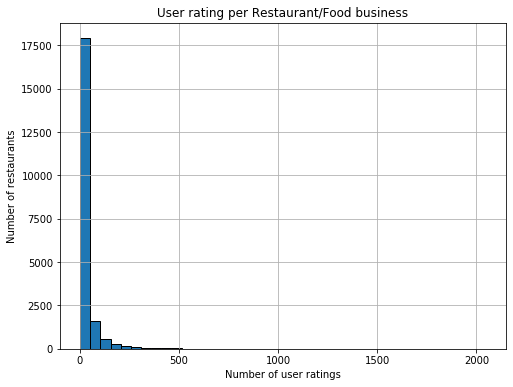

In [89]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
s_business_ratings['rating_counts'].hist(bins=40)
plt.title("User rating per Restaurant/Food business")
plt.xlabel("Number of user ratings")
plt.ylabel("Number of restaurants")

### Most of restaurants/food busniesses have few number of user ratings.

<Figure size 576x432 with 0 Axes>

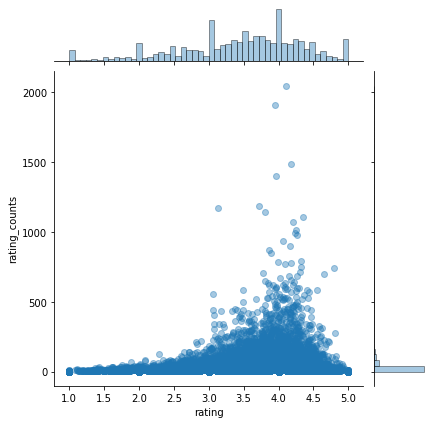

In [90]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=s_business_ratings, alpha=0.4)

### Similar to other business categories, restaurants with more ratings tend to have a higher mean rating in general.

In [91]:
s1 = sample.drop_duplicates(subset='business_id', keep="first")

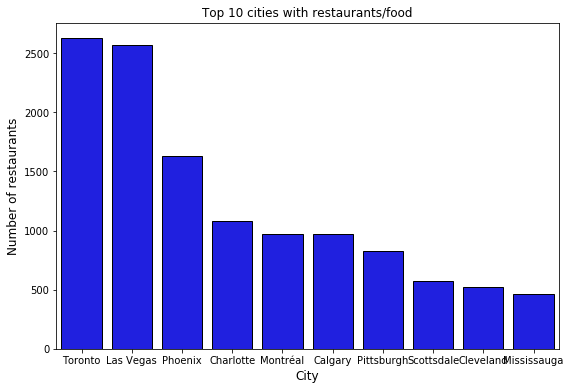

In [92]:
x = s1['city'].value_counts().sort_values(ascending = False).iloc[0:10]
plt.figure(figsize=(9,6))
ax = sns.barplot(x.index, x.values,color="b")
plt.title("Top 10 cities with restaurants/food")
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of restaurants', fontsize=12)
plt.show()

### Toronto has the most number of restaurants/food busniesses narrowly followed by Las Vegas.

In [93]:
is_open1 = pd.DataFrame(s1.groupby('is_open')['business_id'].count())
is_open1

,business_id
is_open,
0,4629
1,16195


### Out of 20,824 restaurants/food businesses, 16,195 are open while 4,629 are closed.

In [94]:
s2 = s1.loc[:, 'American (New)':'Wine & Spirits']

In [95]:
s3 = s2.sum(axis = 0, skipna = True)

In [96]:
s4= pd.DataFrame({'category':s3.index, 'count':s3.values})

In [97]:
s5=s4.sort_values(['count'], ascending=False).iloc[0:10]

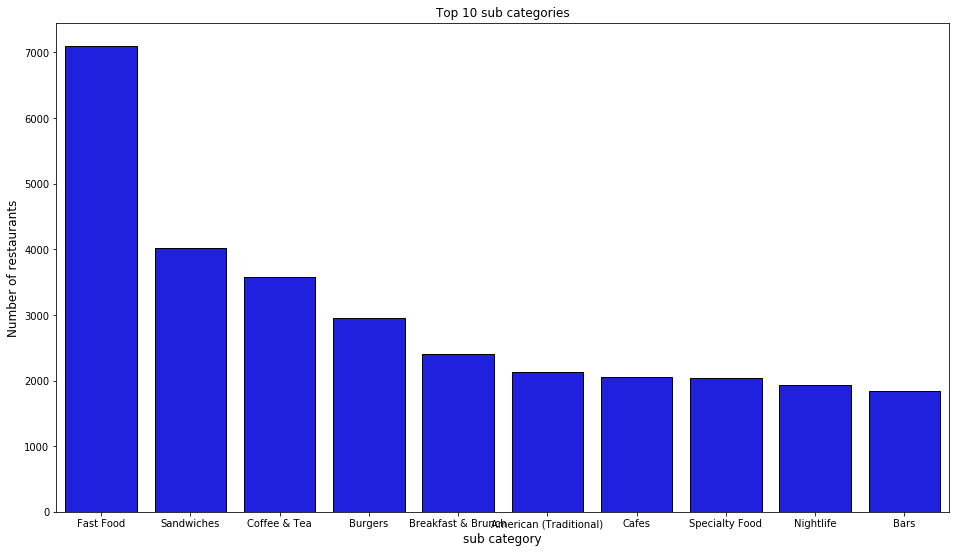

In [98]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x="category", y="count", data=s5,color="b")
plt.title("Top 10 sub categories")
plt.xlabel('sub category', fontsize=12)
plt.ylabel('Number of restaurants', fontsize=12)
plt.show()

### Most of the restaurants/food businesses seem to be types of fast food businesses.